# COVID-19 Infection Spread With Varied Initial Position
In this file, we explored how COVID-19 infection rate differs based on the initial position of the infected molecule. 

In [93]:
# All the imports
from numpy import zeros, arange, sqrt, array, pi
from random import random , uniform 
from pylab import plot, xlabel, ylabel, show

The first step for our algorithm is to calculate, potential energy and radial distribution function to simulate Brownian Motion. 

In [94]:
def force(x,y,rdf):
    
    # Initialize parameters
    w = 50                                # width of the box
    N = 80                                # number of COVID molecules
    dt = 0.02                             # timestep
    m = 1.0                               # mass
    sigma = 3                             # LJ radius
    dr = 0.1*sigma                        # bin width
    sigmaSixth = sigma**6                 # sigma^6
    sigmaTwelfth = sigmaSixth**2          # sigma^12
    epsilon = 1.0                         # LJ well depth
    ljSixth = 4*epsilon*sigmaSixth        # 4*epsilon*sigma**6
    ljTwelfth = 4*epsilon*sigmaTwelfth    # 4*epsilon*sigma**12
    k = 50                                # stiffness of the walls
    nstemp = 50                           # number of time steps before velocity rescaling
    nsgraph = 1000                        # number of time steps before graph output and rdf normalization
    cutoff = 3*sigma                      # cutoff distance for force calculation
    Fx = zeros(N, float)   # x component of net force on each atom
    Fy = zeros(N, float)   # y component of net force on each atom
    func = rdf[:]          # radial distribution function
    U = 0                  # reinitialize total potential energy
    Fwall = 0              # reinitialize total force on walls    
    for i in range(N):

        # collision with walls
        if x[i] < 0.5:
            Fx[i] += k*(0.5 - x[i])
            Fwall += abs(k*(0.5 - x[i]))
            U += 0.5*k*(0.5 - x[i])*(0.5 - x[i])
        elif x[i] > (w - 0.5):
            Fx[i] += k*(w - 0.5 - x[i])
            Fwall += abs(k*(w - 0.5-x[i]))
            U += 0.5*k*(w - 0.5 - x[i])*(w - 0.5 - x[i])
        if y[i] < 0.5:
            Fy[i] += k*(0.5 - y[i])
            Fwall += abs(k*(0.5 - y[i]))
            U += k*(0.5 - y[i])*(0.5 - y[i])
        elif y[i] > (w - 0.5):
            Fy[i] += k*(w - 0.5 - y[i])
            Fwall += abs(k*(w - 0.5 - y[i]))
            U += k*(w - 0.5 - y[i])*(w - 0.5 - y[i])
        
        # Lennard-Jones interaction
        for j in range(i+1, N):
            deltax = x[j] - x[i]
            deltay = y[j] - y[i]
            Rij = sqrt(deltax*deltax + deltay*deltay)
            
            # radial distribution function
            nbin = int(Rij/dr)
            if nbin == 0:
                func[nbin] = 0
            else:
                func[nbin] += 1/(2*pi*nbin*dr)

            # if atoms within cutoff, compute LJ force
            if Rij <= cutoff:
               
                # potential energy
                U += sigmaTwelfth/Rij**12 - sigmaSixth/Rij**6

                # force
                Fijx = (-12*ljTwelfth/Rij**14 + 6*ljSixth/Rij**8)*(x[j] - x[i])
                Fijy = (-12*ljTwelfth/Rij**14 + 6*ljSixth/Rij**8)*(y[j] - y[i])
            
                # net forces
                Fx[i] += Fijx
                Fy[i] += Fijy
                Fx[j] += -Fijx
                Fy[j] += -Fijy
    
    return Fx,Fy,4*epsilon*U, func

Now we define a function that tells us if 2 of the particles have collided or not. 



In [95]:
def collide(i, j, x, y, radiusVal):
    deltax = x[j] - x[i]
    deltay = y[j] - y[i]
    Rij = sqrt(deltax*deltax + deltay*deltay)

    if Rij <= radiusVal * 2 :
        return True 
    return False 

At the next step, we initialize a function that runs the program given particle's initial position. 

In [96]:
def brownian_motion_given_initial_pos(initial_position):

  # # Initialize parameters
  w = 50                                # width of the box
  N = 80                                # number of COVID molecules
  dt = 0.02                             # timestep
  m = 1.0                               # mass
  sigma = 3                             # LJ radius
  T0 = 1.0                              # setpoint temperature
  nstemp = 50                           # number of time steps before velocity rescaling
  totalInfectedNum = 0                  # count of total number of individuals infected

  # arrays for position and velocity
  x = zeros(N, float)
  y = zeros(N, float)  
  vx = array([0.5 - random() for i in range(N)], float)
  vy = array([0.5 - random() for i in range(N)], float)
  vxmid = zeros(N,float)
  vymid = zeros(N,float)

  # radial distribution function
  dr = 0.1*sigma                        # bin width
  numbin = 2*int(w/dr)                  # number of bins
  rdf = zeros(numbin, float)            # initialize to zeros
  rbins = arange(0,dr*numbin,dr)        # r values for each bin

  # atoms
  ball = [] # initialize all molecules
  infected = zeros(N, float) # array that stores all infected individuals

  # initial atom spacing
  dx = w/(int(sqrt(N)) + 1)
  dy = w/(int(sqrt(N)) + 1)
  x0 = 0.5*dx
  y0 = 0.5*dy

  #initalization 
  radiusVal = sigma*2**(1/6)/2

  # initialize positions of molecules
  for i in range(N):
      x[i] = x0
      y[i] = y0

      x0 += dx
      if x0 > w:
          x0 = 0.5*dx
          y0 += dy

  t = 0          # Initialize time
  counter = 0    # Initialize number of time steps

  # Select random molecule to be infected 
  rand = initial_position

  # Make sure that molecule is marked infected and count of infected number of molecules is increased
  infected[rand] = 1
  totalInfectedNum = totalInfectedNum + 1  

  # Perform a half step
  Fx,Fy,U, rdf = force(x,y,rdf)
  vxmid = vx + 0.5*dt*Fx/m
  vymid = vy + 0.5*dt*Fy/m
  K = 0.5*m*sum(vx**2 + vy**2)
  K = 0.5*m*sum(vx**2 + vy**2)
  T = K/N  

  # Initialize arrays to generate graph 
  running = True
  t_values = []
  count_atm = []

  while totalInfectedNum != N:
    
    if running:
        
        # Verlet algorithm
        x += vxmid*dt
        y += vymid*dt
        Fx, Fy, U, rdf = force(x,y,rdf)  # calculate forces,potential energy
        vx = vxmid + 0.5*Fx/m*dt
        vy = vymid + 0.5*Fy/m*dt
        vxmid += Fx/m*dt
        vymid += Fy/m*dt
         
        K = 0.5*m*sum(vx*vx + vy*vy) # kinetic energy
        T = K/N                      # temperature

        # Update atom positions
        for i in range(N):
            
            # set other mols to be infected if atom is infected
            if infected[i] == 1:
                for j in range(N):
                    if j != i and infected[j] == 0:
                        if collide(i, j, x, y, radiusVal):
                            infected[j] = 1
                            totalInfectedNum = totalInfectedNum + 1
                    

        
        # Thermostat
        if counter % nstemp == 0 and counter > 0:
            if T == 0:
                for i in range(N):
                    vxmid[i] = 1.0 - random()
                    vymid[i] = 1.0 - random()
            else:
                gamma = sqrt(T0/T)
                vxmid *= gamma
                vymid *= gamma

        t_values.append(t)
        count_atm.append(totalInfectedNum)
        counter += 1 # number of timesteps
        t += dt      # increase time        

  # Make the plots 
  plot(t_values, count_atm) 
  xlabel("Number of people infected")
  ylabel("Number of infected people")

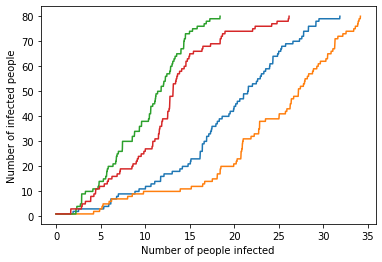

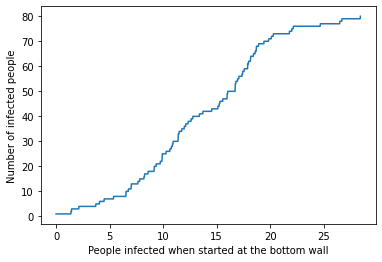

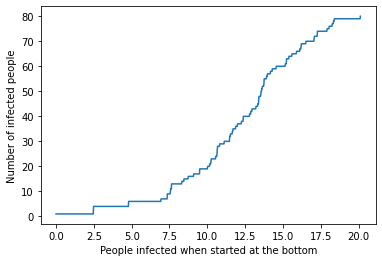

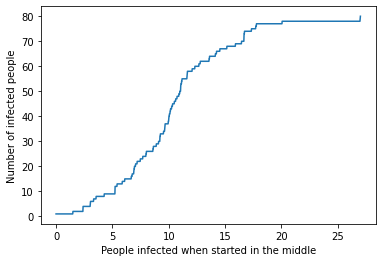

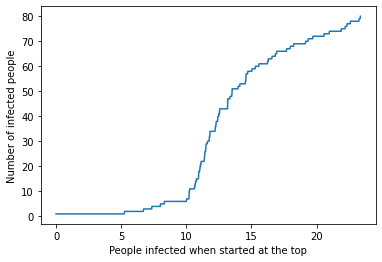

In [97]:
# Initialize a set of initial positions 
initial_positions = [0, 20, 40, 60]
labels = ["People infected when started at the bottom wall", 
          "People infected when started at the bottom", 
          "People infected when started in the middle",
          "People infected when started at the top"]

# Make graphs for different initial positions 
for i in range(len(initial_positions)):
  curr_pos = initial_positions[i]
  # Make the graph 
  brownian_motion_given_initial_pos(curr_pos)

show()
# Also make the graph separately 
for i in range(len(initial_positions)):
  curr_pos = initial_positions[i]
  # Make the graph 
  brownian_motion_given_initial_pos(curr_pos)
  xlabel(labels[i])
  show()

We saw that if the person starts at the middle, they will infect initially at a higher rate than if they started close to the wall, but in the long run it takes about the same amount of time to infect everyone.